In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras import Input
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization

In [10]:
# 꽃 이미지가 저장된 폴더에서 이미지 파일 가져오기 & 라벨링
# X: 꽃 이미지 파일을 numpy 배열로 변환하여 X 배열에 저장
# Z: 꽃 이미지 마다 라벨(꽃 이름)을 영문자열로 Z 배열에 저장

X=[]
Z=[]
IMG_SIZE=224
FLOWER_DAISY_DIR='/content/drive/MyDrive/인공지능/12주차 실습자료/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/인공지능/12주차 실습자료/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/인공지능/12주차 실습자료/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/인공지능/12주차 실습자료/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/인공지능/12주차 실습자료/flowers/rose'

In [11]:
from tqdm import tqdm
import os
import cv2

# 폴더에 저장된 이미지 파일들을 Numpy 데이터로 변환
def make_train_data(flower_type, DIR):
    for img in tqdm(os.listdir(DIR)):
      label = flower_type
      path = os.path.join(DIR, img)
      img2 = cv2.imread(path, cv2.IMREAD_COLOR)
      img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))

      X.append(img2)
      Z.append(label)

In [12]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


50


100%|██████████| 50/50 [00:08<00:00,  6.13it/s]


100


100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


150


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


200


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]

250


In [13]:
# Z 배열에 저장된 꽃 이름(문자열)을 원핫인코딩 방식으로 변환하여 Y 배열에 저장
# X 배열에 저장된 꽃 이미지는 모든 값을 255로 나누어줌
# 입력 값을 1보다 작은 값으로 만들기 위함

le = LabelEncoder()
tmp = le.fit_transform(Z)
Y = pd.get_dummies(tmp).values

X = np.array(X)
X = X/255.0

In [14]:
# 1. 데이터 준비: 훈련 데이터와 시험 데이터로 분할하기

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((200, 224, 224, 3), (50, 224, 224, 3), (200, 5), (50, 5))

In [16]:
# 2-1. 모델 구성하기(컨볼루션 네트워크인 상단부는 InceptionV3 네트워크 모델 사용)

# 케라스에서 제공하는 InceptionV3 네트워크 모델 사용하기
# include_top=False: 이미지를 분류하는 Flatten 레이어부터 Dense레이어까지는 포함하지 않음
# weights='imagenet': ImageNet 데이터세트로 사전 훈련한 가중치 값 사용

in_s = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=in_s)
inception_model.trainable = False

inception_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [17]:
# 2-2. 모델 구성하기(이미지 분류 레이어 추가하기)

# InceptionV3 네트워크 모델의 이미지 분류 레이어 추가하기

model = Sequential()

# 이미지의 특징을 추출하는 컨볼루션 레이어는 InceptionV3 모델을 사용
model.add(inception_model)

# Flatten 레이어 추가
model.add(Flatten())

# 이미지 분류를 위한 Dense 레이어 추가
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 2048)              104859648 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 5

In [19]:
# 3. 모델 학습과정 설정하기

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
# 이미지 데이터 증폭을 위한 설정
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [21]:
# 4. 모델 학습시키기
# 준비된 데이터세트만으로 학습 시킬 때

# 이미지 데이터를 증폭시키면서 학습 시킬 때
hist = model.fit(datagen.flow(x_train, y_train), epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
7/7 [==============================] - 22s 1s/step - loss: 76.2855 - accuracy: 0.2700 - val_loss: 26.6012 - val_accuracy: 0.5200
Epoch 2/50
7/7 [==============================] - 3s 427ms/step - loss: 35.1853 - accuracy: 0.3350 - val_loss: 15.1997 - val_accuracy: 0.4200
Epoch 3/50
7/7 [==============================] - 3s 423ms/step - loss: 16.7756 - accuracy: 0.5050 - val_loss: 11.6630 - val_accuracy: 0.4400
Epoch 4/50
7/7 [==============================] - 3s 432ms/step - loss: 12.0922 - accuracy: 0.5250 - val_loss: 4.4730 - val_accuracy: 0.6400
Epoch 5/50
7/7 [==============================] - 3s 430ms/step - loss: 10.4228 - accuracy: 0.5350 - val_loss: 2.5927 - val_accuracy: 0.7400
Epoch 6/50
7/7 [==============================] - 3s 427ms/step - loss: 5.9950 - accuracy: 0.6450 - val_loss: 3.4836 - val_accuracy: 0.6600
Epoch 7/50
7/7 [==============================] - 3s 427ms/step - loss: 4.9045 - accuracy: 0.6950 - val_loss: 2.2600 - val_accuracy: 0.7400
Epoch 8/50
7/7

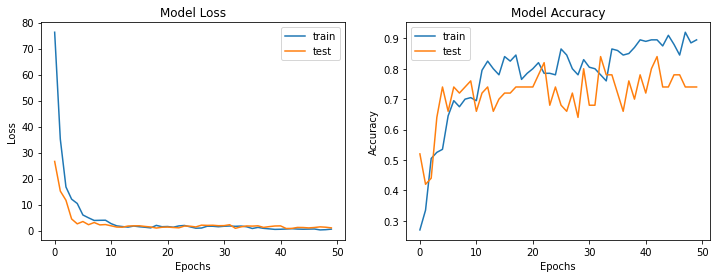

In [22]:
# 5. 학습과정 살펴보기
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [23]:
# 6. 학습된 모델 성능 평가하기
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 153ms/step - loss: 1.0421 - accuracy: 0.7400


[1.0421382188796997, 0.7400000095367432]

In [24]:
# 7. 학습된 모델로 예측하기
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

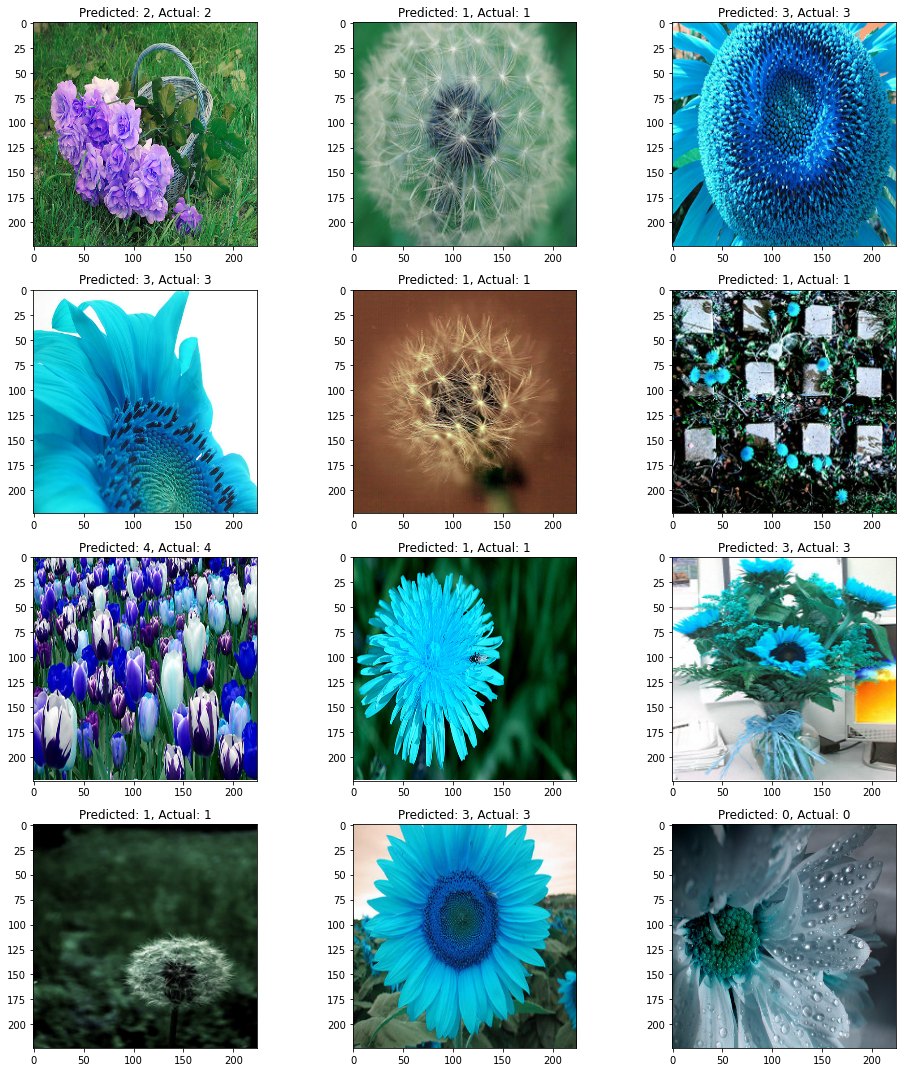

In [25]:
i=0
prop_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==12):
        break

count=0
fig,ax=plt.subplots(4,3)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (3):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted: " + str(pred_digits[prop_class[count]]) + ", Actual: " + str(np.argmax([y_test[prop_class[count]]])))
        plt.tight_layout()
        count+=1

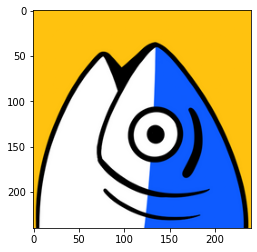

In [28]:
# 8. 인터넷에서 다운로드 받은 이미지로 모델 예측 결과 확인하기
import cv2

tuna = plt.imread('/content/drive/MyDrive/인공지능/12주차 실습자료/flowers/tuna.png')
plt.imshow(tuna)


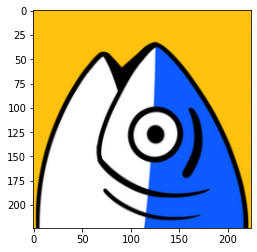

In [30]:
# 이미지 사이즈 조정
tuna = cv2.resize(tuna, (IMG_SIZE, IMG_SIZE))
plt.imshow(tuna)

In [39]:
# 이미지 데이터 타입 변경 및 255로 나누기
tuna = tuna.reshape(1, IMG_SIZE, IMG_SIZE, 3).astype('float32')/255.0
tuna.shape

ValueError: ignored

In [40]:
# 결과 확인하기
np.argmax(model.predict(tuna), axis=1)

ValueError: ignored